# Step 1. 

In [ ]:
# install ultralytics library to use YOLO with pytorch
%pip install ultralytics

In [2]:
#Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import yaml
import time

from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib.patches import Rectangle
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchinfo import summary

2024-03-20 02:07:47.257006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 02:07:47.257124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 02:07:47.410920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Confirm avilable GPU
print("Available GPU :",torch.cuda.is_available())

print("Current device :",torch.cuda.current_device())

print("Device :",torch.cuda.device(0))

print("Device name :",torch.cuda.get_device_name(0))

Available GPU : True
Current device : 0
Device : <torch.cuda.device object at 0x7ef1eb1fe8f0>
Device name : Tesla P100-PCIE-16GB


In [4]:
#Define path directory variables
root = '/kaggle/input/wider-face-a-face-detection-benchmark/'
train_img_folder = f"{root}wider_train/WIDER_train/images/"
val_img_folder = f"{root}wider_val/WIDER_val/images/"
annotations_folder = f"{root}wider_face_split/wider_face_split/"

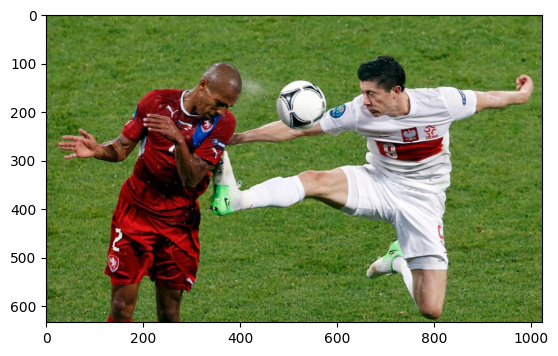

In [5]:
#See one image from train folder
img = Image.open(f"{train_img_folder}37--Soccer/37_Soccer_Soccer_37_23.jpg")
plt.imshow(img)

In [6]:
#List of files in the annotation folder
os.listdir(annotations_folder)

['wider_face_train_bbx_gt.txt',
 'wider_face_val_bbx_gt.txt',
 'wider_face_test.mat',
 'readme.txt',
 'wider_face_val.mat',
 'wider_face_test_filelist.txt',
 'wider_face_train.mat']

*The bounding box information inside the text files should be in the following format:*

> File name
> 
> Number of bounding boxes
> 
> x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose

Therefore, a custom loader will be needed. Let's create a function to extract all important annotations from each of the files.

In [7]:
#Path for train and validation bounding box
train_bbx_path = f"{annotations_folder}wider_face_train_bbx_gt.txt"
val_bbx_path = f"{annotations_folder}wider_face_val_bbx_gt.txt"

#Define function to extract annotations to a list of dictionaries 
#Along with a list of the keys in separate lists
def load_bbx(bbx_path):
    with open(bbx_path, mode='r') as file:
        lines = file.readlines()
        
    annotations = {}
    i = 0
    while i < len(lines):
        file_name = lines[i].strip()
        i += 1
        num_boxes = int(lines[i].strip())
        i += 1
        boxes = []
        for _ in range(num_boxes):
            box_info = lines[i].strip().split()
            box = {
                'x': int(box_info[0]),
                'y': int(box_info[1]),
                'w': int(box_info[2]),
                'h': int(box_info[3]),
            }
            boxes.append(box)
            i += 1
        annotations[file_name] = boxes

    return annotations

In [8]:
#List of train annotations
train_annotations = load_bbx(train_bbx_path)
#List of validation annotations
val_annotations = load_bbx(val_bbx_path)

#List of keys in train_annotations
train_keys = [key for key in train_annotations.keys()]
#List of keys in val_annotations
val_keys = [key for key in val_annotations.keys()]

In [9]:
#Each key is tne name of the image
train_keys[2]

'0--Parade/0_Parade_marchingband_1_799.jpg'

In [10]:
#Inside each image key there is a list of dictionaries with all the bounding boxes for faces
train_annotations[train_keys[2]]

[{'x': 78, 'y': 221, 'w': 7, 'h': 8},
 {'x': 78, 'y': 238, 'w': 14, 'h': 17},
 {'x': 113, 'y': 212, 'w': 11, 'h': 15},
 {'x': 134, 'y': 260, 'w': 15, 'h': 15},
 {'x': 163, 'y': 250, 'w': 14, 'h': 17},
 {'x': 201, 'y': 218, 'w': 10, 'h': 12},
 {'x': 182, 'y': 266, 'w': 15, 'h': 17},
 {'x': 245, 'y': 279, 'w': 18, 'h': 15},
 {'x': 304, 'y': 265, 'w': 16, 'h': 17},
 {'x': 328, 'y': 295, 'w': 16, 'h': 20},
 {'x': 389, 'y': 281, 'w': 17, 'h': 19},
 {'x': 406, 'y': 293, 'w': 21, 'h': 21},
 {'x': 436, 'y': 290, 'w': 22, 'h': 17},
 {'x': 522, 'y': 328, 'w': 21, 'h': 18},
 {'x': 643, 'y': 320, 'w': 23, 'h': 22},
 {'x': 653, 'y': 224, 'w': 17, 'h': 25},
 {'x': 793, 'y': 337, 'w': 23, 'h': 30},
 {'x': 535, 'y': 311, 'w': 16, 'h': 17},
 {'x': 29, 'y': 220, 'w': 11, 'h': 15},
 {'x': 3, 'y': 232, 'w': 11, 'h': 15},
 {'x': 20, 'y': 215, 'w': 12, 'h': 16}]

**Dataset**

> The YOLOv5 algorithm expects the annotations to be in a text file with a center instead of a top-left corner defined, therefore we need to convert the annotations to a dataframe, which will be later converted to a text file

In [12]:
#Create a small sample of train and validation so that training does not take that much time this is
#For initial experiments, final model will be trained in full training dataset

print("Train keys        :",len(train_keys))
print("Train Annotations :",len(train_annotations))
print("\n")
print("Val keys          :",len(val_keys))
print("Val Annotations   :",len(val_annotations))

Train keys        : 12880
Train Annotations : 12880


Val keys          : 3226
Val Annotations   : 3226


In [13]:
n = 6000
m = 600
small_train_keys = train_keys[0:n] #First n observations
small_val_keys = val_keys[0:m]#First m observations

print("small train keys :",len(small_train_keys))
print("small val keys   :",len(small_val_keys))

small train keys : 6000
small val keys   : 600


In [14]:
#Function that creates df from annotation
def annotation_to_df(annotation, img_shape):
    cs, xs, ys, ws, hs = [], [], [], [], []
    
    h, w, _ = img_shape
    for box in annotation:
        cs.append(0)
        xs.append((box["x"] + box["w"] / 2.0) / w)
        ys.append((box["y"] + box["h"] / 2.0) / h)
        ws.append(box["w"] / w)
        hs.append(box["h"] / h)
        
    return pd.DataFrame({0:cs, 1:xs, 2:ys, 3:ws, 4:hs})

#Function to plot bounding boxes
def plot_boxes(img, df):
    h, w, _ = img.shape
    
    fig, ax = plt.subplots()
    for index, row in df.iterrows():
        patch = Rectangle(
            ((row[1] - row[3] / 2.0) * w, (row[2] - row[4] / 2.0) * h),
            row[3] * w,
            row[4] * h,
            edgecolor = 'red',
            fill=False,
        )
        ax.add_patch(patch)
    
    plt.imshow(img)

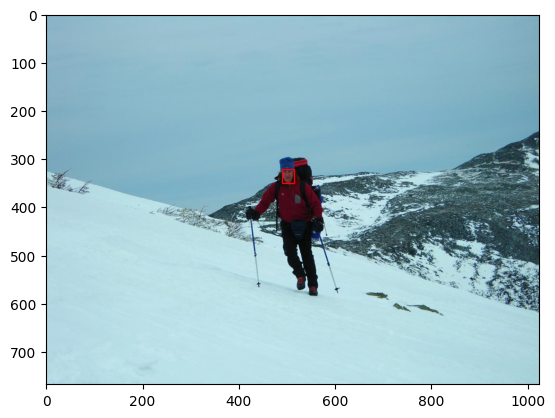

In [17]:
#Exmaple

#Take random img from train folder and select key 
key = train_keys[random.randint(0, len(train_keys) - 1)]

#Cast img to numpy array
img = np.array(Image.open(f"{train_img_folder}{key}"))

#Create df using annotations and img
df = annotation_to_df(train_annotations[key], img.shape)

#Plot
plot_boxes(img, df)

The data is expected to be in this structure:

In [18]:
#datasets
#│
#└── facest
#    │
#    ├── images
#    │   ├── train
#    │   └── val
#    │
#    └── labels
#        ├── train
#        └── val

We will copy the images from the dataset into the correct structure and add text files with the annotations. Running the cells bellow might take a while.

In [19]:
def add_dataset(keys, annotations, img_folder, root, split):
    if not os.path.exists(root):
        os.makedirs(root)
    if not os.path.exists(f"{root}images/{split}"):
        os.makedirs(f"{root}images/{split}")
        os.makedirs(f"{root}labels/{split}")
    
    for i, key in enumerate(keys):
        img = np.array(Image.open(f"{img_folder}{key}"))
        Image.fromarray(img).save(f"{root}images/{split}/im{i}.jpg")
        df = annotation_to_df(annotations[key], img.shape)
        df.to_csv(f"{root}labels/{split}/im{i}.txt", header=False, index=False, sep='\t')

In [20]:
len(train_keys), len(val_keys)

(12880, 3226)

In [21]:
len(small_train_keys), len(small_val_keys)

(6000, 600)

In [22]:
train_keys_ctrl = small_train_keys
add_dataset(train_keys_ctrl, train_annotations, train_img_folder, "/kaggle/working/datasets/faceset/", "train")

In [23]:
val_keys_ctrl = small_val_keys
add_dataset(val_keys_ctrl, val_annotations, val_img_folder, "/kaggle/working/datasets/faceset/", "val")

In [24]:
# using YOLOv5 for fine tunning 

#clone repo
!git clone https://github.com/ultralytics/yolov5

#Install requirements
%cd yolov5
%pip install -r "requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16517, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 16517 (delta 47), reused 50 (delta 16), pack-reused 16402
Receiving objects: 100% (16517/16517), 15.18 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (11307/11307), done.
/kaggle/working/yolov5
/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
Note: you may need to restart the kernel to use updated packages.


In [25]:
#Create a file that specifies folders and classes, there is only 1 clss
dict_file = {"path":"../datasets/faceset",
             "train":"images/train",
             "val":"images/val",
             "nc":0,
             "names": ["face"]}

with open("/kaggle/working/yolov5/data/dataset.yaml", 'w') as file:
    documents = yaml.dump(dict_file, file)

In [ ]:
#Fine tune model
#Also measure how much time it takes to do this

start = time.time()
!python train.py --img 640 --epochs 12 --batch-size 32 --data dataset.yaml --weights yolov5s.pt --device 0
end = time.time()

print("\n")
print("Fine Tunning Time :", round((end-start),2))

In [27]:
#Load Custom model to test it
custom_yolov5 = torch.hub.load('/kaggle/working/yolov5', 'custom', 
                               path='runs/train/exp/weights/best.pt', 
                               force_reload=True, source='local')

YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [28]:
# Changing settings to prevent finding the faces multiple times
custom_yolov5.conf = 0.5
custom_yolov5.iou = 0.3

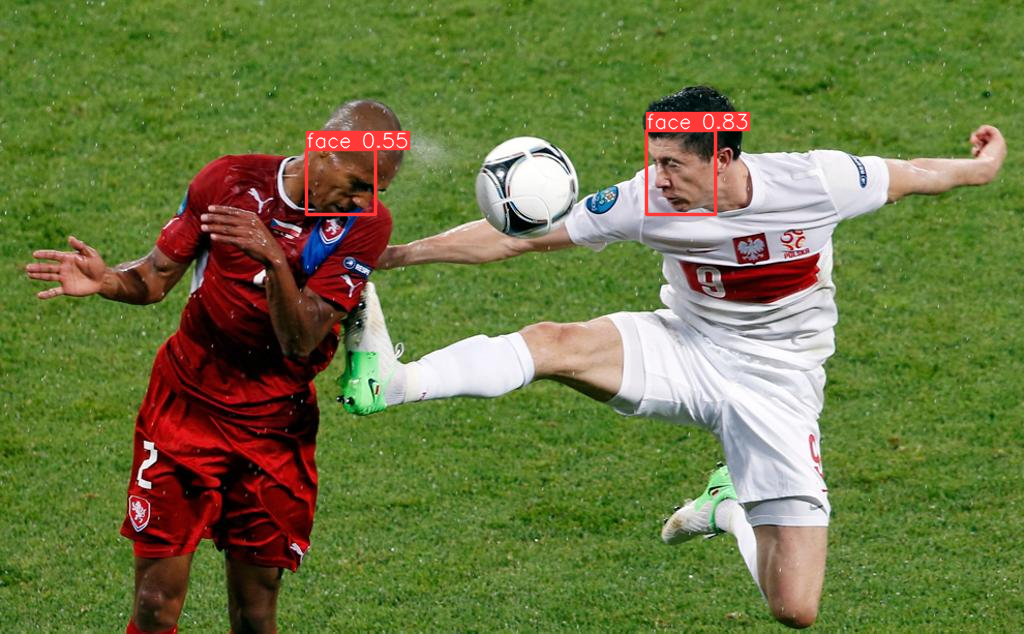

Inference time : 0.55


In [29]:
#Measure how much time it takes to make an inference
start = time.time()
output = custom_yolov5(f"{train_img_folder}37--Soccer/37_Soccer_Soccer_37_23.jpg")
end = time.time()
output.show()
print("Inference time :", round(end-start, 2))

Inference time : 0.08


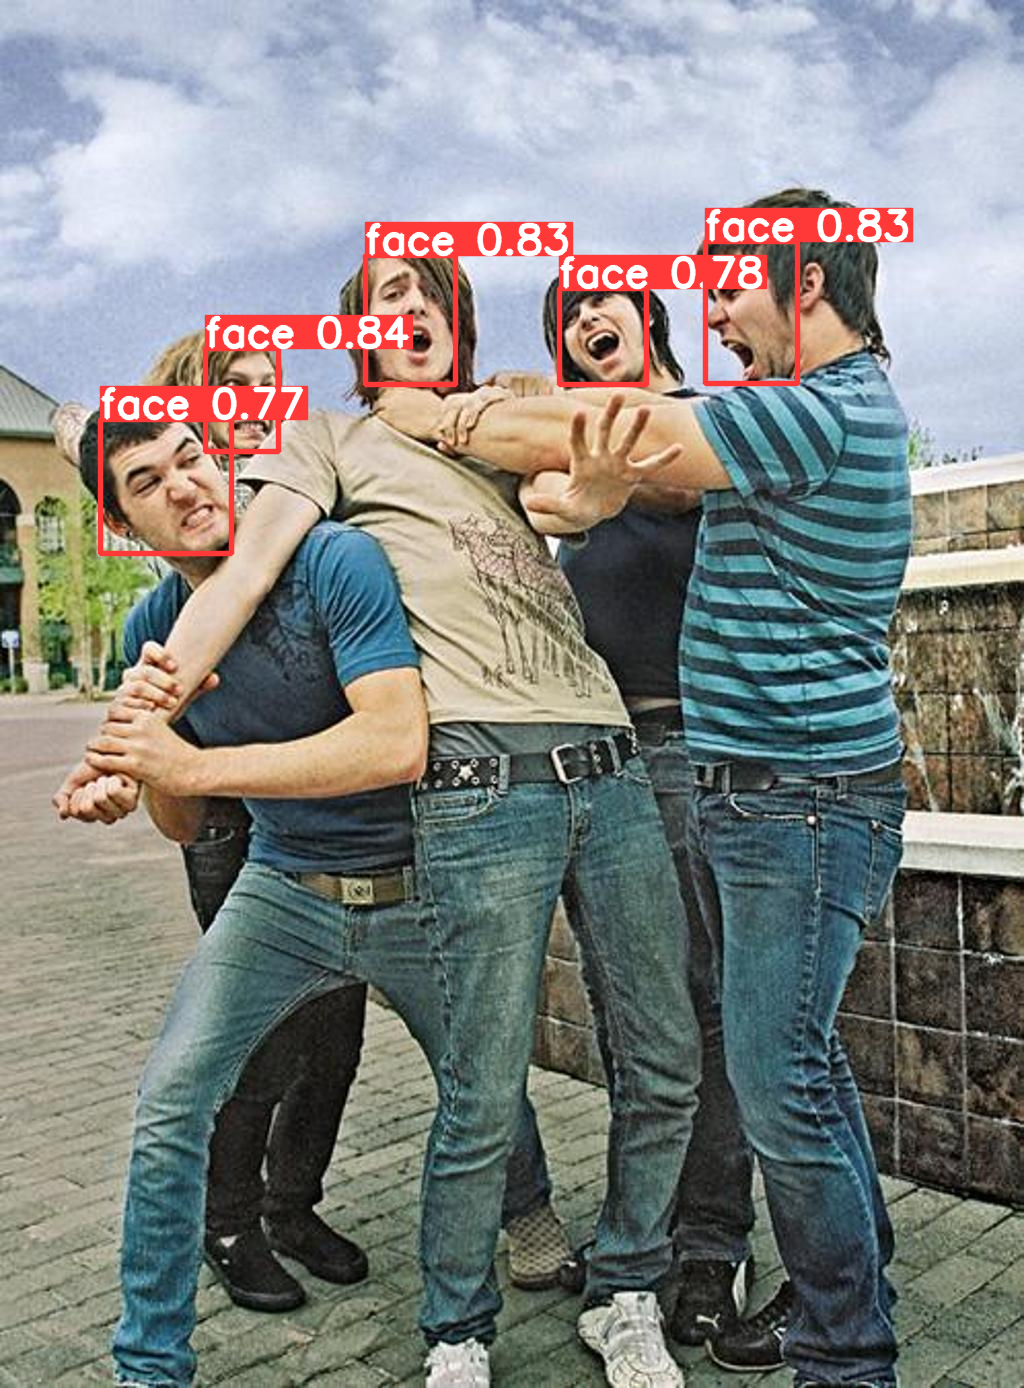

In [30]:
start = time.time()
output = custom_yolov5(f"{val_img_folder}{val_keys[3]}")
end = time.time()
print("Inference time :", round(end-start, 2))
output.show()

In [ ]:
#Save training outputs
!zip -r file.zip /kaggle/working/yolov5/runs/train

In [32]:
!ls

CITATION.cff	 __pycache__	export.py	requirements.txt  utils
CONTRIBUTING.md  benchmarks.py	file.zip	runs		  val.py
LICENSE		 classify	hubconf.py	segment		  yolov5s.pt
README.md	 data		models		train.py
README.zh-CN.md  detect.py	pyproject.toml	tutorial.ipynb


In [33]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/yolov5/file.zip

In [34]:
!cd /kaggle/working

In [ ]:
#Save training outputs
!zip -r file.zip /kaggle/working/yolov5/runs/train

In [36]:
!ls

CITATION.cff	 __pycache__	export.py	requirements.txt  utils
CONTRIBUTING.md  benchmarks.py	file.zip	runs		  val.py
LICENSE		 classify	hubconf.py	segment		  yolov5s.pt
README.md	 data		models		train.py
README.zh-CN.md  detect.py	pyproject.toml	tutorial.ipynb


In [37]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/yolov5/file.zip